In [1]:
%matplotlib inline
import numpy as np
import lib.io.stan
import lib.plots.stan
import lib.utils.stan
import subprocess
import matplotlib.pyplot as plt
import os 
from matplotlib.lines import Line2D
import importlib

In [2]:
data_dir = 'datasets/id002_cj'
results_dir = 'results/exp10/exp10.57.13'
os.makedirs(results_dir,exist_ok=True)
os.makedirs(f'{results_dir}/logs',exist_ok=True)
os.makedirs(f'{results_dir}/figures',exist_ok=True)

network = np.load(f'{data_dir}/CJ_network.npz')
SC = network['SC']
K = np.max(SC)
SC = SC / K
SC[np.diag_indices(SC.shape[0])] = 0
gain_mat = network['gain_mat']

slp = np.load(f'{data_dir}/CJ_fit_trgt.npz')['fit_trgt']
#slp_ds = slp
slp_ds = slp[0:-1:10,:]
#slp_ds = slp_ds[20:250,:]
snsr_pwr = np.mean(slp_ds**2, axis=0)
# snsr_pwr = snsr_pwr / snsr_pwr.max()

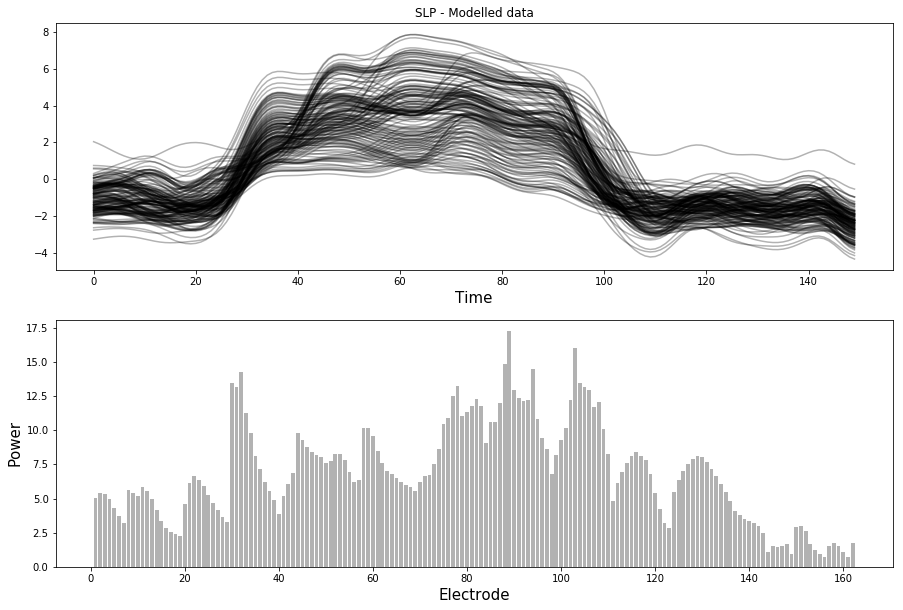

In [3]:
plt.figure(figsize=(15,10))
plt.subplot(211)
plt.plot(slp_ds, color='black', alpha=0.3);
plt.xlabel('Time', fontsize=15)
plt.title('SLP - Modelled data')
plt.subplot(212)
plt.bar(np.arange(1,gain_mat.shape[0]+1), snsr_pwr, color='black', alpha=0.3)
plt.xlabel('Electrode', fontsize=15)
plt.ylabel('Power', fontsize=15)
plt.savefig(f'{results_dir}/figures/fitting_data.png')

In [4]:
nn = SC.shape[0]
ns = gain_mat.shape[0]
nt = slp_ds.shape[0]

stan_fname = 'exp10.57.13'

x0_star_star = np.zeros(nn)
amplitude_star_star = 0
offset_star_star = 0
K_star_star = 0
tau0_star_star = 0

param_init = {'x0_star_star':x0_star_star, 'amplitude_star_star':amplitude_star_star,
              'offset_star_star':offset_star_star, 'K_star_star':K_star_star,
              'tau0_star_star':tau0_star_star}

param_init_file = 'param_init.R'
os.makedirs(f'{results_dir}/Rfiles',exist_ok=True)
lib.io.stan.rdump(f'{results_dir}/Rfiles/param_init.R', param_init)

max_depth = 20
delta = 0.95
fname_suffix = f'hyper_fixed_md{max_depth}_delta{delta}'

data = {'nn':nn, 'ns':ns, 'nt':nt, 'SC':SC, 'gain': gain_mat,
        'slp':slp_ds, 'snsr_pwr':snsr_pwr}
input_Rfile = f'fit_data_snsrfit_ode_{fname_suffix}.R'
os.makedirs(f'{results_dir}/Rfiles',exist_ok=True)
lib.io.stan.rdump(f'{results_dir}/Rfiles/{input_Rfile}',data)

In [5]:
%%bash -s "$stan_fname"
# stancompile.sh $1
/home/anirudhnihalani/scripts/stancompile.sh $1

/home/anirudhnihalani/tngdesktop

--- Translating Stan model to C++ code ---
bin/stanc  /home/anirudhnihalani/tngdesktop/exp10.57.13.stan --o=/home/anirudhnihalani/tngdesktop/exp10.57.13.hpp
Model name=exp10_57_13_model
Input file=/home/anirudhnihalani/tngdesktop/exp10.57.13.stan
Output file=/home/anirudhnihalani/tngdesktop/exp10.57.13.hpp

--- Linking C++ model ---
g++ -Wall -I . -isystem stan/lib/stan_math/lib/eigen_3.3.3 -isystem stan/lib/stan_math/lib/boost_1.66.0 -isystem stan/lib/stan_math/lib/sundials_3.1.0/include -std=c++1y -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -DBOOST_PHOENIX_NO_VARIADIC_EXPRESSION -Wno-unused-function -Wno-uninitialized -I src -isystem stan/src -isystem stan/lib/stan_math/ -DFUSION_MAX_VECTOR_SIZE=12 -Wno-unused-local-typedefs -DEIGEN_NO_DEBUG -pthread -DNO_FPRINTF_OUTPUT -pipe   src/cmdstan/main.cpp  -O3 -o /home/anirudhnihalani/tngdesktop/exp10.57.13 -include /home/anirudhnihalani/tngdesktop/exp10.57.13.hpp stan/lib/stan_mat

DIAGNOSTIC(S) FROM PARSER:



In [6]:
%%bash -s "$stan_fname" "$results_dir" "$input_Rfile" "$fname_suffix" "$max_depth" "$delta"

STAN_FNAME=$1
RESULTS_DIR=$2
INPUT_RFILE=$3
FNAME_SUFFIX=$4
MAX_DEPTH=$5
DELTA=$6

for i in {1..2};
do
./${STAN_FNAME} id=$((100*${i})) sample num_samples=2000 num_warmup=2000 \
save_warmup=0 adapt engaged=1 delta=${DELTA} algorithm=hmc engine=nuts max_depth=${MAX_DEPTH} \
stepsize_jitter=0.8 data file=${RESULTS_DIR}/Rfiles/${INPUT_RFILE} \
init=${RESULTS_DIR}/Rfiles/param_init.R random seed=$((987*${i})) \
output file=${RESULTS_DIR}/samples_${FNAME_SUFFIX}_chain${i}.csv refresh=10 \
&> ${RESULTS_DIR}/logs/snsrfit_ode_${FNAME_SUFFIX}_chain${i}.log &
done

In [ ]:
print(np.argsort(pstr_samples_1['x0'].mean(axis=0)))
# pstr_samples_1['x0'].shape
print(ez,pz)
# print(pstr_samples_1['time_step'].mean(axis=0))

#### Plots for each chain separately

In [8]:
importlib.reload(lib.plots.stan)
syn_data = np.load('datasets/id002_cj/CJ_syn_tvb_ez=6-34_pz=27-5-11.npz')
fit_data = lib.io.stan.rload(f'{results_dir}/Rfiles/fit_data_snsrfit_ode_{fname_suffix}.R')
x0_true = syn_data['x0']
ez = syn_data['ez']
pz= np.concatenate((syn_data['pz_x0'], syn_data['pz_kplng']))
szng_roi = np.setxor1d(ez, pz)
non_szng_roi = np.setdiff1d(np.r_[0:nn], szng_roi)

variables_of_interest = ['lp__','accept_stat__','stepsize__','treedepth__','n_leapfrog__',\
                         'divergent__', 'energy__','x0',  'x', 'z', 'mu_slp', 'mu_snsr_pwr',\
                         'amplitude', 'offset', 'tau0', 'K', 'alpha']
chains = [1,2]
nwarmup = 0
nsampling = 0
params = ['tau0', 'amplitude', 'offset', 'K', 'alpha']
for chain_no in chains:
    pstr_samples = lib.io.stan.read_samples([f'{results_dir}/samples_{fname_suffix}_chain{chain_no}.csv'],
                                      variables_of_interest=variables_of_interest, nwarmup=nwarmup, nsampling=nsampling)
#     for var in pstr_samples.keys():
#        pstr_samples[var] = pstr_samples[var][200:]
    lib.plots.stan.x0_violin_syn(pstr_samples['x0'], x0_true, ez, pz, figsize=(25,5),
                                 figname=f'{results_dir}/figures/x0_violin_{fname_suffix}_chain{chain_no}.png',
                                 legend_loc='lower right')
    lib.plots.stan.nuts_diagnostics(pstr_samples, figsize=(15,10), figname=f'{results_dir}/figures/nuts_diagnostics_{fname_suffix}_chain{chain_no}.png')
    lib.plots.stan.pair_plots(samples=pstr_samples, params=params, 
                              figname=f'{results_dir}/figures/params_pair_plots_{fname_suffix}_chain{chain_no}.png',
                              sampler='HMC')
    
    x_pp_mean = np.mean(pstr_samples['x'], axis=0)
    z_pp_mean = np.mean(pstr_samples['z'], axis=0)
    lib.plots.stan.plot_source(x_pp_mean, z_pp_mean, ez, pz,
                               figname=f'{results_dir}/figures/posterior_predicted_src_{fname_suffix}_chain{chain_no}.png')
    lib.plots.stan.plot_phase(x_pp_mean, z_pp_mean, ez, pz, non_szng_roi,
                              figname=f'{results_dir}/figures/posterior_predicted_phase_plot_{fname_suffix}_chain{chain_no}.png')

    slp = pstr_samples['mu_slp'].mean(axis=0)
    snsr_pwr = pstr_samples['mu_snsr_pwr'].mean(axis=0)
    lib.plots.stan.plot_fit_target(data_pred={'slp':slp,'snsr_pwr':snsr_pwr}, data_true={'slp':fit_data['slp'],'snsr_pwr':fit_data['snsr_pwr']},
                               figname=f'{results_dir}/figures/posterior_predicted_slp_{fname_suffix}_chain{chain_no}.png')

Exception: csv file does not contain warmup samples, nwarmup must be     zero

In [ ]:
5/150

In [ ]:
xlims = [-2.5,1.0]
ylims = [2,]
plt.figure(figsize=(25,5))
plt.subplot(131)
plt.plot(x_pp_mean[:,ez], z_pp_mean[:,ez])
plt.xlim(xlims)
plt.ylim(ylims)
plt.xlabel(r'$x$', fontsize=15, fontweight='bold')
plt.ylabel(r'$z$', fontsize=15, fontweight='bold')
plt.title('EZ', fontsize=15, fontweight='bold')
plt.subplot(132)
plt.plot(x_pp_mean[:,pz], z_pp_mean[:,pz])
plt.xlim(xlims)
plt.ylim(ylims)
plt.title('PZ', fontsize=15, fontweight='bold')
plt.xlabel(r'$x$', fontsize=15, fontweight='bold')
plt.ylabel(r'$z$', fontsize=15, fontweight='bold')
plt.subplot(133)
plt.plot(x_pp_mean[:,t], z_pp_mean[:,t], color='black')
plt.xlim(xlims)
plt.ylim(ylims)
plt.title('Rest', fontsize=15, fontweight='bold')
plt.xlabel(r'$x$', fontsize=15, fontweight='bold')
plt.ylabel(r'$z$', fontsize=15, fontweight='bold')

#### Plots with samples from all chains merged

In [ ]:
pstr_samples = lib.io.stan.read_samples([f'{results_dir}/samples_{fname_suffix}_chain{i}.csv' for i in chains],
                                      variables_of_interest=variables_of_interest, nwarmup=nwarmup, nsampling=nsampling)

lib.plots.stan.x0_violin_syn(pstr_samples['x0'], x0_true, ez, pz, figsize=(25,5), figname=f'{results_dir}/figures/x0_violin_{fname_suffix}.png')
lib.plots.stan.nuts_diagnostics(pstr_samples, figsize=(15,10), figname=f'{results_dir}/figures/nuts_diagnostics_{fname_suffix}.png')
lib.plots.stan.pair_plots(pstr_samples, params)

x_pp_mean = np.mean(pstr_samples['x'], axis=0)
z_pp_mean = np.mean(pstr_samples['z'], axis=0)
lib.plots.stan.plot_source(x_pp_mean, z_pp_mean, ez, pz, f'{results_dir}/figures/posterior_predicted_src_{fname_suffix}.png')

slp = pstr_samples['mu_slp'].mean(axis=0)
snsr_pwr = pstr_samples['mu_snsr_pwr'].mean(axis=0)
lib.plots.stan.plot_fit_target(data_pred={'slp':slp,'snsr_pwr':snsr_pwr}, data_true={'slp':fit_data['slp'],'snsr_pwr':fit_data['snsr_pwr']},
                               figname=f'{results_dir}/figures/posterior_predicted_slp_{fname_suffix}.png')

